CustomerId: Her müşteri için benzersiz bir tanımlayıcı.

Surname: Müşterinin soyadı.

CreditScore: Müşterinin kredi puanı.

Geography: Müşterinin coğrafi konumu (ör. ülke veya bölge).

Gender: Müşterinin cinsiyeti.

Age: Müşterinin yaşı.

Tenure: Müşterinin çalıştığı zaman.

Balance: Müşterinin hesap bakiyesidir.

NumOfProducts: Müşterinin sahip olduğu banka ürünlerinin sayısı.

HasCrCard: Müşterinin kredi kartının olup olmadığını belirtir (ikili: evet/hayır)..

IsActiveMember: Müşterinin aktif üye olup olmadığını belirtir (ikili: evet/hayır).

EstimatedSalary: Müşterinin tahmini maaşı.

Exited: Müşterinin bankadan çıkıp çıkmadığını belirtir (ikili: evet/hayır).

# IMPORT AND DATASET

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
df = pd.read_csv("Churn_Modelling.csv")

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


# GENEL RESIM

In [5]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

check_df(df)

##################### Shape #####################
(10000, 14)
##################### Types #####################
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object
##################### NA #####################
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

In [7]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 10000
Variables: 14
cat_cols: 6
num_cols: 7
cat_but_car: 1
num_but_cat: 4


In [8]:
df.head(1)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1


In [9]:
# kategorik değişkenlerin analizi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

cat_summary(df, "Exited")

        Exited  Ratio
Exited               
0         7963 79.630
1         2037 20.370
##########################################


In [10]:
#kategorik değişkenlerin target'a göre analizi
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Exited", col)

Geography
           TARGET_MEAN  Count  Ratio
Geography                           
France           0.162   5014 50.140
Germany          0.324   2509 25.090
Spain            0.167   2477 24.770


Gender
        TARGET_MEAN  Count  Ratio
Gender                           
Female        0.251   4543 45.430
Male          0.165   5457 54.570


NumOfProducts
               TARGET_MEAN  Count  Ratio
NumOfProducts                           
1                    0.277   5084 50.840
2                    0.076   4590 45.900
3                    0.827    266  2.660
4                    1.000     60  0.600


HasCrCard
           TARGET_MEAN  Count  Ratio
HasCrCard                           
0                0.208   2945 29.450
1                0.202   7055 70.550


IsActiveMember
                TARGET_MEAN  Count  Ratio
IsActiveMember                           
0                     0.269   4849 48.490
1                     0.143   5151 51.510


Exited
        TARGET_MEAN  Count  Ratio
Exited    

count   10000.000
mean     5000.500
std      2886.896
min         1.000
5%        500.950
10%      1000.900
20%      2000.800
30%      3000.700
40%      4000.600
50%      5000.500
60%      6000.400
70%      7000.300
80%      8000.200
90%      9000.100
95%      9500.050
99%      9900.010
max     10000.000
Name: RowNumber, dtype: float64


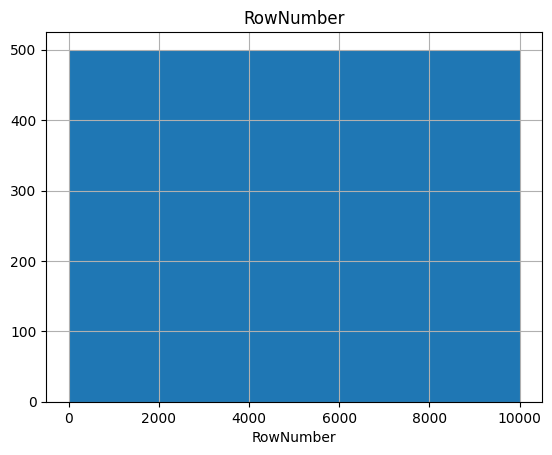

count      10000.000
mean    15690940.569
std        71936.186
min     15565701.000
5%      15578824.200
10%     15591167.100
20%     15616377.400
30%     15641363.900
40%     15665787.600
50%     15690738.000
60%     15715686.600
70%     15740461.600
80%     15765818.800
90%     15790830.700
95%     15803034.300
99%     15813113.190
max     15815690.000
Name: CustomerId, dtype: float64


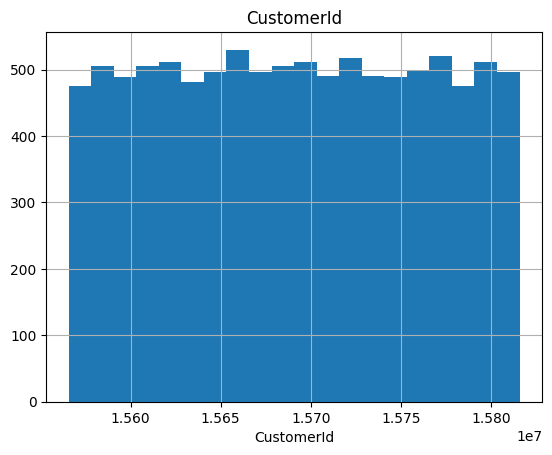

count   10000.000
mean      650.529
std        96.653
min       350.000
5%        489.000
10%       521.000
20%       566.000
30%       598.700
40%       627.000
50%       652.000
60%       678.000
70%       704.000
80%       735.000
90%       778.000
95%       812.000
99%       850.000
max       850.000
Name: CreditScore, dtype: float64


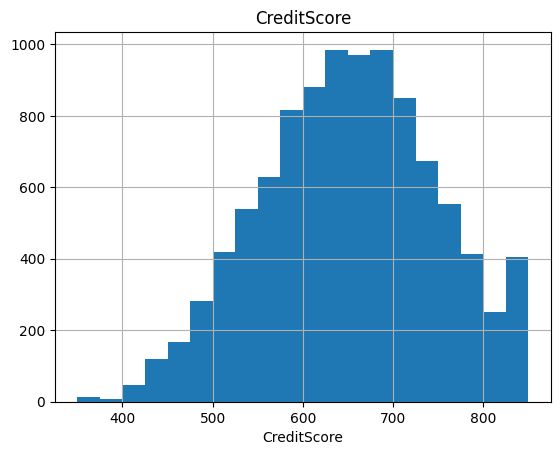

count   10000.000
mean       38.922
std        10.488
min        18.000
5%         25.000
10%        27.000
20%        31.000
30%        33.000
40%        35.000
50%        37.000
60%        40.000
70%        42.000
80%        46.000
90%        53.000
95%        60.000
99%        72.000
max        92.000
Name: Age, dtype: float64


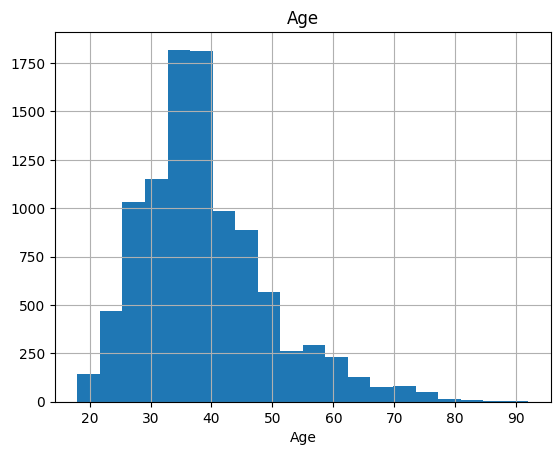

count   10000.000
mean        5.013
std         2.892
min         0.000
5%          1.000
10%         1.000
20%         2.000
30%         3.000
40%         4.000
50%         5.000
60%         6.000
70%         7.000
80%         8.000
90%         9.000
95%         9.000
99%        10.000
max        10.000
Name: Tenure, dtype: float64


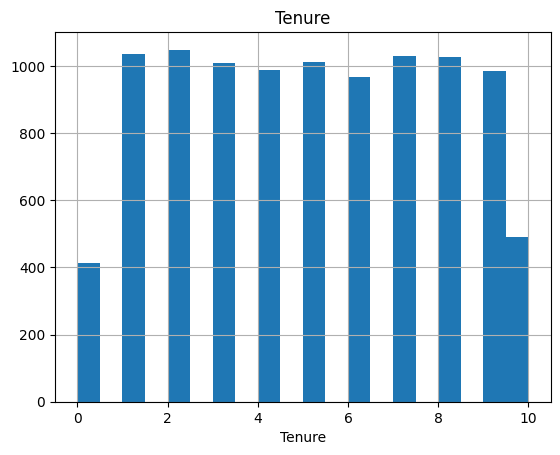

count    10000.000
mean     76485.889
std      62397.405
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%      73080.908
50%      97198.540
60%     110138.926
70%     122029.870
80%     133710.358
90%     149244.792
95%     162711.669
99%     185967.985
max     250898.090
Name: Balance, dtype: float64


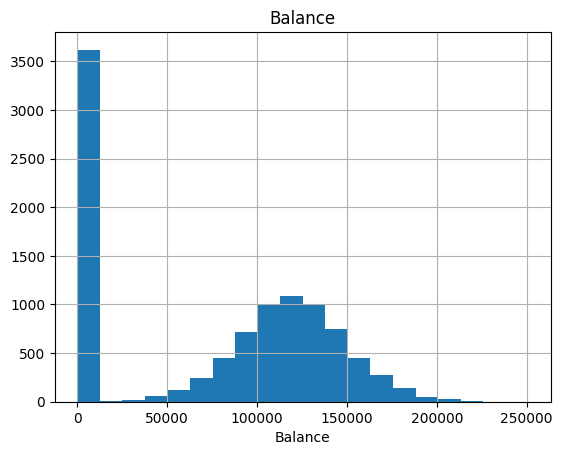

count    10000.000
mean    100090.240
std      57510.493
min         11.580
5%        9851.819
10%      20273.580
20%      41050.736
30%      60736.079
40%      80238.340
50%     100193.915
60%     119710.038
70%     139432.236
80%     159836.726
90%     179674.704
95%     190155.375
99%     198069.734
max     199992.480
Name: EstimatedSalary, dtype: float64


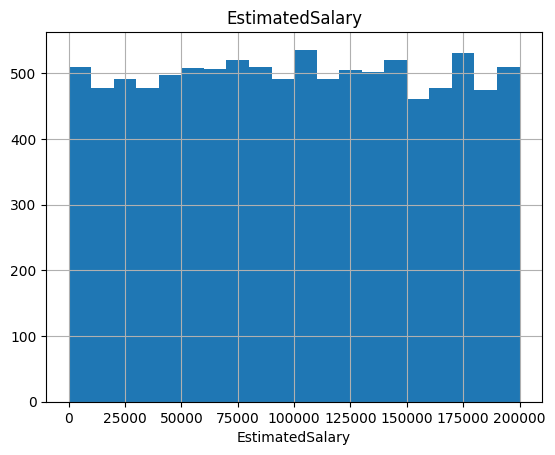

In [11]:
# numerik değişkenlerin analizi
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

In [12]:
# Korelasyon analizi
df[num_cols].corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,EstimatedSalary
RowNumber,1.000,0.004,0.006,0.001,-0.006,-0.009,-0.006
CustomerId,0.004,1.000,0.005,0.009,-0.015,-0.012,0.015
CreditScore,0.006,0.005,1.000,-0.004,0.001,0.006,-0.001
Age,0.001,0.009,-0.004,1.000,-0.010,0.028,-0.007
Tenure,-0.006,-0.015,0.001,-0.010,1.000,-0.012,0.008
Balance,-0.009,-0.012,0.006,0.028,-0.012,1.000,0.013
EstimatedSalary,-0.006,0.015,-0.001,-0.007,0.008,0.013,1.000


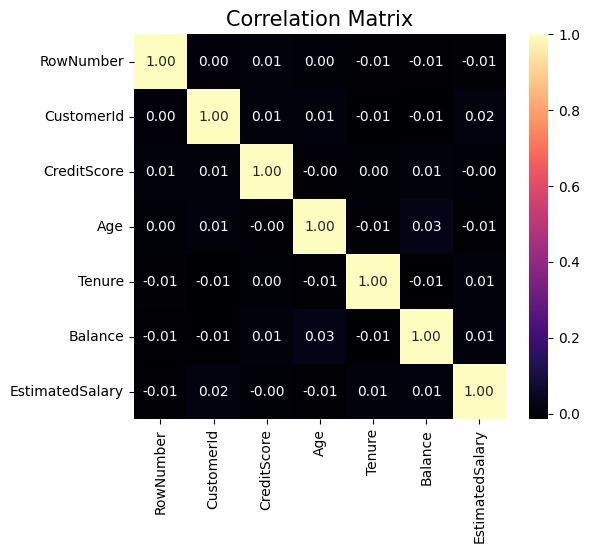

In [13]:
# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[6, 5])
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=15)
plt.show()

# OUTLİERS

In [14]:
# Outlier formül fonk. yazalım
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [15]:
# outlier kontrol etme fonk.
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [16]:
# aykırı değerimiz yok
for col in num_cols:
    print(col, check_outlier(df, col))

RowNumber False
CustomerId False
CreditScore False
Age False
Tenure False
Balance False
EstimatedSalary False


# FEATURE EXTRACTION

In [17]:
def min_max(dataframe, col_name):
  en_kucuk = min(dataframe[col_name])
  en_buyuk = max(dataframe[col_name])
  print("En küçük değer:", en_kucuk)
  print("En büyük değer:", en_buyuk)


In [18]:
min_max(df, "Age")

En küçük değer: 18
En büyük değer: 92


In [19]:
min_max(df, "Balance")

En küçük değer: 0.0
En büyük değer: 250898.09


In [20]:
min_max(df, "EstimatedSalary")

En küçük değer: 11.58
En büyük değer: 199992.48


In [21]:
min_max(df, "Tenure")

En küçük değer: 0
En büyük değer: 10


In [22]:
# yaş değişkeninden yeni bir değişken çıkaralım
df.loc[(df['Age'] >= 18) & (df['Age'] <= 30), 'NEW_AGE_CAT'] = 'young'
df.loc[(df['Age'] > 30) & (df['Age'] < 60), 'NEW_AGE_CAT'] = 'mature'
df.loc[(df['Age'] >= 60), 'NEW_AGE_CAT'] = 'senior'

# müşteri yaşı ve kredi skoru kombinasyonu değişkeni
df['NEW_AGE_CREDIT_SCORE_CAT'] = df["Age"] * df["CreditScore"]

# müşterinin hesap bakiyesiyle yeni bir değişken oluşturalım.
df['NEW_BALANCE_VALUE_CAT'] = pd.cut(df['Balance'], bins=[0, 100000.00, 200000.00, 250898.09], labels=['low', 'mid', 'high'], include_lowest=True)

# müşterinin maaşıyla ilgili yeni bir değişken oluşturalım
df['NEW_ESTIMATED_SALARY_VALUE_CAT'] = pd.cut(df['EstimatedSalary'], bins=[11.58, 70000.00, 140000.00, 199992.48], labels=['low', 'mid', 'high'], include_lowest=True)

# müşterinin bankada nekadar durduğuyla alakalı bir değişken türetelim müşterinin sadakati
df['NEW_CUSTOMER_LOYALTY_CAT'] = pd.cut(df['Tenure'], bins=[0, 5, 10], labels=['low', 'high'], include_lowest=True)

# müşterinin finansal istikrarı hakkında bilgi almak için kredi skoru ile çalışma süresi arasındaki farkı hesaplayalım ve değişken oluşturalım.
df['NEW_CUSTOMER_FINANCIAL_STABILITY_CAT'] = df['CreditScore'] - df['Tenure']




In [23]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,NEW_AGE_CAT,NEW_AGE_CREDIT_SCORE_CAT,NEW_BALANCE_VALUE_CAT,NEW_ESTIMATED_SALARY_VALUE_CAT,NEW_CUSTOMER_LOYALTY_CAT,NEW_CUSTOMER_FINANCIAL_STABILITY_CAT
0,1,15634602,Hargrave,619,France,Female,42,2,0.000,1,1,1,101348.880,1,mature,25998,low,mid,low,617
1,2,15647311,Hill,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0,mature,24928,low,mid,low,607
2,3,15619304,Onio,502,France,Female,42,8,159660.800,3,1,0,113931.570,1,mature,21084,mid,mid,high,494
3,4,15701354,Boni,699,France,Female,39,1,0.000,2,0,0,93826.630,0,mature,27261,low,mid,low,698
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0,mature,36550,mid,mid,low,848


In [24]:
df.shape

(10000, 20)

# ENCODING

In [25]:
# Değişkenlerin tiplerine göre ayrılması işlemi
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 10000
Variables: 20
cat_cols: 10
num_cols: 9
cat_but_car: 1
num_but_cat: 7


LABEL ENCODING

In [26]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [27]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['Gender']

In [28]:
for col in binary_cols:
    df = label_encoder(df, col)

ONE HOT ENCODING

In [29]:
# cat_cols listesinin güncelleme işlemi
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Exited","Surname"]]
cat_cols

['Geography',
 'NEW_AGE_CAT',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'NEW_BALANCE_VALUE_CAT',
 'NEW_ESTIMATED_SALARY_VALUE_CAT',
 'NEW_CUSTOMER_LOYALTY_CAT']

In [30]:
# one hot encoder fonk.
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [31]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [32]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,EstimatedSalary,Exited,NEW_AGE_CREDIT_SCORE_CAT,NEW_CUSTOMER_FINANCIAL_STABILITY_CAT,Geography_Germany,Geography_Spain,NEW_AGE_CAT_senior,NEW_AGE_CAT_young,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,HasCrCard_1,IsActiveMember_1,NEW_BALANCE_VALUE_CAT_mid,NEW_BALANCE_VALUE_CAT_high,NEW_ESTIMATED_SALARY_VALUE_CAT_mid,NEW_ESTIMATED_SALARY_VALUE_CAT_high,NEW_CUSTOMER_LOYALTY_CAT_high
0,1,15634602,Hargrave,619,0,42,2,0.000,101348.880,1,25998,617,False,False,False,False,False,False,False,True,True,False,False,True,False,False
1,2,15647311,Hill,608,0,41,1,83807.860,112542.580,0,24928,607,False,True,False,False,False,False,False,False,True,False,False,True,False,False
2,3,15619304,Onio,502,0,42,8,159660.800,113931.570,1,21084,494,False,False,False,False,False,True,False,True,False,True,False,True,False,True
3,4,15701354,Boni,699,0,39,1,0.000,93826.630,0,27261,698,False,False,False,False,True,False,False,False,False,False,False,True,False,False
4,5,15737888,Mitchell,850,0,43,2,125510.820,79084.100,0,36550,848,False,True,False,False,False,False,False,True,True,True,False,True,False,False


# MODELLEME

In [33]:
y = df["Exited"]
X = df.drop(["Exited","CustomerId","RowNumber","Surname"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

catboost_model = CatBoostClassifier(verbose=False, random_state=12345).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),2)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")


Accuracy: 0.86
Recall: 0.74
Precision: 0.48
F1: 0.58
Auc: 0.81


    Value                               Feature
2  15.320                                   Age
4  13.677                               Balance
12 11.600                       NumOfProducts_2
5   8.338                       EstimatedSalary
6   7.588              NEW_AGE_CREDIT_SCORE_CAT
16  6.709                      IsActiveMember_1
8   6.362                     Geography_Germany
7   6.120  NEW_CUSTOMER_FINANCIAL_STABILITY_CAT
0   5.464                           CreditScore
3   5.280                                Tenure
13  3.592                       NumOfProducts_3
1   3.274                                Gender
19  1.232    NEW_ESTIMATED_SALARY_VALUE_CAT_mid
15  1.100                           HasCrCard_1
9   1.099                       Geography_Spain
17  1.013             NEW_BALANCE_VALUE_CAT_mid
14  0.962                       NumOfProducts_4
20  0.420   NEW_ESTIMATED_SALARY_VALUE_CAT_high
21  0.351         NEW_CUSTOMER_LOYALTY_CAT_high
18  0.231            NEW_BALANCE_VALUE_C

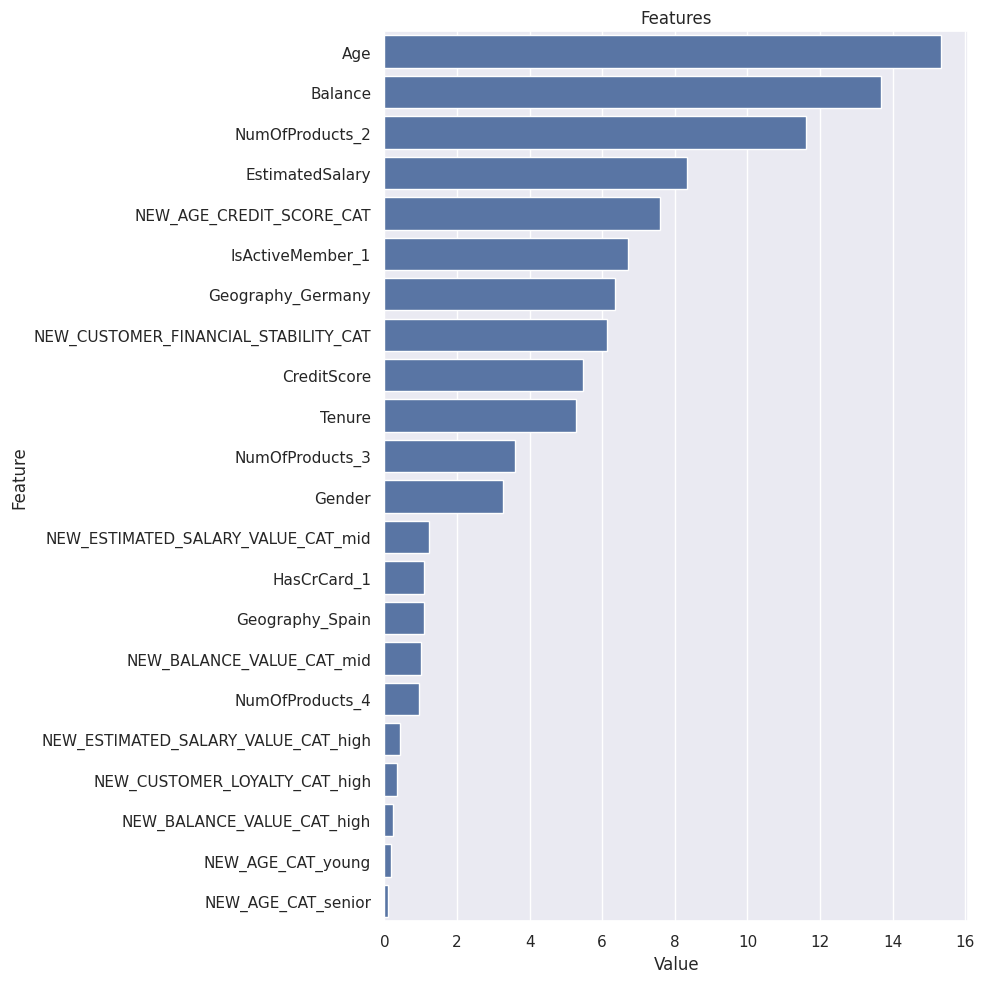

In [34]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(catboost_model, X)